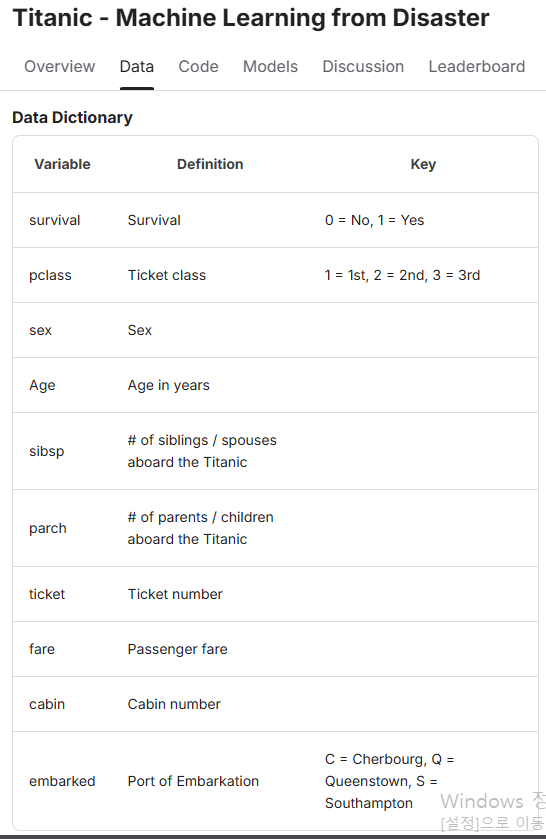


- 종속변수 : survived = 알고 싶은 값, 생존여부 = 라벨
- 독립변수 : 종속변수를 제외한 나머지 7개 컬럼(숫자, 문자) = feature (일부 결측치를 포함하고 있음)

### 명목형 모델
- 분류 모델은 feature들의 데이터를 분석해서 라벨을 분류 예측하는 모델


In [128]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, isnan, when, avg, mean, expr
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [129]:
ss = SparkSession.builder.appName('Titanic').getOrCreate()
ss

24/12/12 17:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [130]:
df = ss.read.csv('data/titanic.csv', header = True, inferSchema = True)
df

DataFrame[survived: int, pclass: int, sex: string, age: double, sibsp: int, parch: int, fare: double, embark_town: string]

In [9]:
df.show(10)

+--------+------+------+----+-----+-----+-------+-----------+
|survived|pclass|   sex| age|sibsp|parch|   fare|embark_town|
+--------+------+------+----+-----+-----+-------+-----------+
|       0|     3|  male|22.0|    1|    0|   7.25|Southampton|
|       1|     1|female|38.0|    1|    0|71.2833|  Cherbourg|
|       1|     3|female|26.0|    0|    0|  7.925|Southampton|
|       1|     1|female|35.0|    1|    0|   53.1|Southampton|
|       0|     3|  male|35.0|    0|    0|   8.05|Southampton|
|       0|     3|  male|null|    0|    0| 8.4583| Queenstown|
|       0|     1|  male|54.0|    0|    0|51.8625|Southampton|
|       0|     3|  male| 2.0|    3|    1| 21.075|Southampton|
|       1|     3|female|27.0|    0|    2|11.1333|Southampton|
|       1|     2|female|14.0|    1|    0|30.0708|  Cherbourg|
+--------+------+------+----+-----+-----+-------+-----------+
only showing top 10 rows



### 결측치(missing value) 확인

In [131]:
null_counts = df.select(
                    [
                        sum(when(col(c).isNull() | isnan(c),1).otherwise(0)).alias(c) for c in df.columns
                        
                    ]    
                )
null_counts.show()

+--------+------+---+---+-----+-----+----+-----------+
|survived|pclass|sex|age|sibsp|parch|fare|embark_town|
+--------+------+---+---+-----+-----+----+-----------+
|       0|     0|  0|177|    0|    0|   0|          2|
+--------+------+---+---+-----+-----+----+-----------+



In [63]:
# feature - ,
# target - survived
data = df.select('survived'
                , 'pclass'
                , 'sex'
                , 'age'
                , 'sibsp'
                , 'parch'
                , 'fare')

data.show(10)

+--------+------+------+----+-----+-----+-------+
|survived|pclass|   sex| age|sibsp|parch|   fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
|       0|     3|  male|null|    0|    0| 8.4583|
|       0|     1|  male|54.0|    0|    0|51.8625|
|       0|     3|  male| 2.0|    3|    1| 21.075|
|       1|     3|female|27.0|    0|    2|11.1333|
|       1|     2|female|14.0|    1|    0|30.0708|
+--------+------+------+----+-----+-----+-------+
only showing top 10 rows



In [64]:
# 나이 결측치를 평균으로 대체하기
mean_age = data.select('age')\
            .agg({'age' : 'mean'}).collect()[0][0]
             #age 컬럼에서 mean 값을 구하겠다는 뜻
mean_age

29.69911764705882

In [65]:
data = data.fillna({'age' : mean_age})
data.show()

+--------+------+------+-----------------+-----+-----+-------+
|survived|pclass|   sex|              age|sibsp|parch|   fare|
+--------+------+------+-----------------+-----+-----+-------+
|       0|     3|  male|             22.0|    1|    0|   7.25|
|       1|     1|female|             38.0|    1|    0|71.2833|
|       1|     3|female|             26.0|    0|    0|  7.925|
|       1|     1|female|             35.0|    1|    0|   53.1|
|       0|     3|  male|             35.0|    0|    0|   8.05|
|       0|     3|  male|29.69911764705882|    0|    0| 8.4583|
|       0|     1|  male|             54.0|    0|    0|51.8625|
|       0|     3|  male|              2.0|    3|    1| 21.075|
|       1|     3|female|             27.0|    0|    2|11.1333|
|       1|     2|female|             14.0|    1|    0|30.0708|
|       1|     3|female|              4.0|    1|    1|   16.7|
|       1|     1|female|             58.0|    0|    0|  26.55|
|       0|     3|  male|             20.0|    0|    0| 

### encoding ::
category type => numeric (sex를 0 또는 1)

In [68]:
indexer = StringIndexer(inputCol = 'sex', outputCol = 'sexIndex')
data = indexer.fit(data).transform(data)
data.show()

+--------+------+------+-----------------+-----+-----+-------+--------+
|survived|pclass|   sex|              age|sibsp|parch|   fare|sexIndex|
+--------+------+------+-----------------+-----+-----+-------+--------+
|       0|     3|  male|             22.0|    1|    0|   7.25|     0.0|
|       1|     1|female|             38.0|    1|    0|71.2833|     1.0|
|       1|     3|female|             26.0|    0|    0|  7.925|     1.0|
|       1|     1|female|             35.0|    1|    0|   53.1|     1.0|
|       0|     3|  male|             35.0|    0|    0|   8.05|     0.0|
|       0|     3|  male|29.69911764705882|    0|    0| 8.4583|     0.0|
|       0|     1|  male|             54.0|    0|    0|51.8625|     0.0|
|       0|     3|  male|              2.0|    3|    1| 21.075|     0.0|
|       1|     3|female|             27.0|    0|    2|11.1333|     1.0|
|       1|     2|female|             14.0|    1|    0|30.0708|     1.0|
|       1|     3|female|              4.0|    1|    1|   16.7|  

### Feature Vectorrized

In [69]:
assembler = VectorAssembler(
    inputCols = ['pclass'
                , 'sexIndex'
                , 'age'
                , 'sibsp'
                , 'parch'
                , 'fare'], #하나 또는 리스트
    
    outputCol =  'feature' #output은 하나
)

data = assembler.transform(data)
data

DataFrame[survived: int, pclass: int, sex: string, age: double, sibsp: int, parch: int, fare: double, sexIndex: double, feature: vector]

In [70]:
# 지도 학습, 분류모델을 학습시키기 위한 데이터
data.select('survived'
            , 'feature')\
    .show()

+--------+--------------------+
|survived|             feature|
+--------+--------------------+
|       0|[3.0,0.0,22.0,1.0...|
|       1|[1.0,1.0,38.0,1.0...|
|       1|[3.0,1.0,26.0,0.0...|
|       1|[1.0,1.0,35.0,1.0...|
|       0|[3.0,0.0,35.0,0.0...|
|       0|[3.0,0.0,29.69911...|
|       0|[1.0,0.0,54.0,0.0...|
|       0|[3.0,0.0,2.0,3.0,...|
|       1|[3.0,1.0,27.0,0.0...|
|       1|[2.0,1.0,14.0,1.0...|
|       1|[3.0,1.0,4.0,1.0,...|
|       1|[1.0,1.0,58.0,0.0...|
|       0|[3.0,0.0,20.0,0.0...|
|       0|[3.0,0.0,39.0,1.0...|
|       0|[3.0,1.0,14.0,0.0...|
|       1|[2.0,1.0,55.0,0.0...|
|       0|[3.0,0.0,2.0,4.0,...|
|       1|[2.0,0.0,29.69911...|
|       0|[3.0,1.0,31.0,1.0...|
|       1|[3.0,1.0,29.69911...|
+--------+--------------------+
only showing top 20 rows



### ML 모델
데이터 학습 > 평가 > 모델 완성

1) DataSet 분할

In [73]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed = 42 ) #return 값 목록1, 값 목록2
#값 목록1 : 0.8 >> 80% 0.2 >> 20%
#seed로 값 고정함

train_data.show(), test_data.show()

+--------+------+------+-----------------+-----+-----+--------+--------+--------------------+
|survived|pclass|   sex|              age|sibsp|parch|    fare|sexIndex|             feature|
+--------+------+------+-----------------+-----+-----+--------+--------+--------------------+
|       0|     1|female|              2.0|    1|    2|  151.55|     1.0|[1.0,1.0,2.0,1.0,...|
|       0|     1|female|             25.0|    1|    2|  151.55|     1.0|[1.0,1.0,25.0,1.0...|
|       0|     1|  male|             18.0|    1|    0|   108.9|     0.0|[1.0,0.0,18.0,1.0...|
|       0|     1|  male|             19.0|    1|    0|    53.1|     0.0|[1.0,0.0,19.0,1.0...|
|       0|     1|  male|             19.0|    3|    2|   263.0|     0.0|[1.0,0.0,19.0,3.0...|
|       0|     1|  male|             22.0|    0|    0|135.6333|     0.0|[1.0,0.0,22.0,0.0...|
|       0|     1|  male|             24.0|    0|    1|247.5208|     0.0|[1.0,0.0,24.0,0.0...|
|       0|     1|  male|             27.0|    0|    2|   211

(None, None)

### 분류 예측 model 생성
- 로지스틱 회귀

분류 모델 : 라벨 ( 타겟 ), Feature

In [78]:
# 로지스틱 회귀 모델 생성
lr = LogisticRegression(featuresCol='feature', labelCol = 'survived')

In [80]:
# 모델 학습
lr_model \
= lr.fit( train_data ) # 전체 중 80%에 해당하는 학습 데이터 > y값(라벨, 타겟)을 결정할 수 있도록, 매개 변수를 확정

In [82]:
# 모델 시험 :: 테스트 데이터 > 결과 확인 - 데이터의 답이 들어 있다 > 모델이 맞춘 y값
# 그래서 우리는 이를 지도학습이라 부름 (훈련 데이터에도 정답이 있고, 모델을 시험하는 데이터에도 정답이 있음)
predictions = lr_model.transform( test_data )
predictions.show()

+--------+------+------+-----------------+-----+-----+--------+--------+--------------------+--------------------+--------------------+----------+
|survived|pclass|   sex|              age|sibsp|parch|    fare|sexIndex|             feature|       rawPrediction|         probability|prediction|
+--------+------+------+-----------------+-----+-----+--------+--------+--------------------+--------------------+--------------------+----------+
|       0|     1|female|             50.0|    0|    0| 28.7125|     1.0|[1.0,1.0,50.0,0.0...|[-1.9520246347246...|[0.12433276014445...|       1.0|
|       0|     1|  male|             21.0|    0|    1| 77.2875|     0.0|[1.0,0.0,21.0,0.0...|[-0.5063684917057...|[0.37604522093222...|       1.0|
|       0|     1|  male|             24.0|    0|    0|    79.2|     0.0|[1.0,0.0,24.0,0.0...|[-0.5000163743656...|[0.37753682076914...|       1.0|
|       0|     1|  male|             29.0|    0|    0|    30.0|     0.0|[1.0,0.0,29.0,0.0...|[-0.1615623337462...|[0.4

In [84]:
predictions.select(
                'feature'
                ,'survived'
                ,'prediction'   
)\
.show()

+--------------------+--------+----------+
|             feature|survived|prediction|
+--------------------+--------+----------+
|[1.0,1.0,50.0,0.0...|       0|       1.0|
|[1.0,0.0,21.0,0.0...|       0|       1.0|
|[1.0,0.0,24.0,0.0...|       0|       1.0|
|[1.0,0.0,29.0,0.0...|       0|       1.0|
|[1.0,0.0,29.69911...|       0|       1.0|
|[1.0,0.0,29.69911...|       0|       1.0|
|[1.0,0.0,29.69911...|       0|       1.0|
|[1.0,0.0,36.0,0.0...|       0|       0.0|
|[1.0,0.0,44.0,2.0...|       0|       0.0|
|[1.0,0.0,45.0,0.0...|       0|       0.0|
|[1.0,0.0,45.0,0.0...|       0|       0.0|
|[1.0,0.0,45.5,0.0...|       0|       0.0|
|[1.0,0.0,46.0,1.0...|       0|       0.0|
|[1.0,0.0,47.0,0.0...|       0|       0.0|
|[1.0,0.0,54.0,0.0...|       0|       0.0|
|[1.0,0.0,61.0,0.0...|       0|       0.0|
|[1.0,0.0,70.0,1.0...|       0|       0.0|
|[2.0,0.0,23.0,0.0...|       0|       0.0|
|[2.0,0.0,26.0,0.0...|       0|       0.0|
|[2.0,0.0,28.0,0.0...|       0|       0.0|
+----------

#### 정답 개수 확인

In [90]:
p1 = predictions.withColumn('survived', col('survived').cast(IntegerType()))
p2 = predictions.withColumn('prediction', col('prediction').cast(IntegerType()))

In [104]:
# correct columns 추가
compare = predictions.withColumn('correct', expr('CASE WHEN survived = prediction THEN 1 ELSE 0 END'))
print(f"전체 테스트 데이터 20% 중, {compare.where('correct = 0').count()}개가 틀렸습니다.")

전체 테스트 데이터 20% 중, 28개가 틀렸습니다.


In [117]:
predictions.createOrReplaceTempView('predictions_table')

ss.sql('''
    SELECT
        feature
        , CASE WHEN
            CAST(survived as INT) = CAST(prediction as INT) THEN 1
                ELSE 0 END as correct
        
    FROM predictions_table
    WHERE (CAST(survived as INT) = CAST(prediction as INT)) = 0
''')\
.count()


28

#### 정확도 계산 > 모델의 점수

In [119]:
accu = compare.selectExpr('avg(correct) as accuracy').collect()[0]['accuracy']
accu

0.8068965517241379

### 평가기 evaluator

In [123]:
# 모델별로 평가지표, 매트릭
# 분류모델의 평가지표 중에서 AUC 계산한다.

evaluator = BinaryClassificationEvaluator(labelCol = 'survived', rawPredictionCol = 'rawPrediction', metricName = 'areaUnderROC')
evaluator

BinaryClassificationEvaluator_18e1e4ab0fef

In [125]:
auc = evaluator.evaluate(predictions)
auc

0.8664129586260734

In [126]:
ss.stop()